In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import sys; sys.path.append("src/")
from models import AutoregTheoryModel
from my_datasets import \
    hot, AutoregDataset, FactAmnesiaDataset, SuppressRuleDataset, CoerceStateDataset
from exp_utils import load_model_and_dataset

In [2]:
# Directory and device setup
saveto_dir = "_dump"
models_dir = "_saved_models"
device = "cuda" if torch.cuda.is_available() else "cpu"
do_ln = True

In [3]:
@torch.no_grad()
def run_one_fact_amensia_attack(
    num_props,
    num_repeats,
    num_samples = 2048,
    batch_size = 2048,
    kappa = 100,
    verbose = False,
):
    assert num_samples % batch_size == 0
    n, k, bsz = num_props, num_repeats, batch_size
    zn = torch.zeros(bsz,1,n,device=device)
    model, _ = load_model_and_dataset(n, num_samples, models_dir, do_layer_norm=do_ln)
    model.eval().to(device)
    dataloader = DataLoader(FactAmnesiaDataset(n,k,num_samples), bsz)
    elems_acc, state_acc = [], [] # Stats to track
    for batch in dataloader:
        infos = batch["infos"].to(device)
        a, b, c, d, e, f, g, h = infos.chunk(infos.size(-1), dim=-1)
        init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)
        atk_rule = torch.cat([zn, -kappa*hot(a,n)], dim=-1).view(bsz,1,2*n)
        adv_suffix = torch.cat([atk_rule.repeat(1,k,1), init_token], dim=1)
        out = model(torch.cat([batch["tokens"].to(device), adv_suffix], dim=1))
        pred = (out.logits > 0).long()
        labels = batch["labels"].to(device)
        elems_acc.append((pred == labels).float().mean().cpu().item())
        state_acc.append((pred == labels).all(dim=-1).float().mean().cpu().item())

    elems_acc = torch.tensor(elems_acc).float().mean().item()
    state_acc = torch.tensor(state_acc).float().mean().item()

    if verbose:
        print(f"num_props {n}, repeats {k}, elems {elems_acc:.3f}, state {state_acc:.3f}")
    return {
        "elems_acc": elems_acc,
        "state_acc": state_acc,
    }

In [4]:
max_repeats = 24
fa_16_rets, fa_32_rets, fa_48_rets, fa_64_rets = [], [], [], []
for k in tqdm(range(1,max_repeats+1)):
    fa_16_rets.append(run_one_fact_amensia_attack(num_props=16, num_repeats=k))
    fa_32_rets.append(run_one_fact_amensia_attack(num_props=32, num_repeats=k))
    fa_48_rets.append(run_one_fact_amensia_attack(num_props=48, num_repeats=k))
    fa_64_rets.append(run_one_fact_amensia_attack(num_props=64, num_repeats=k))

  0%|          | 0/24 [00:00<?, ?it/s]

''

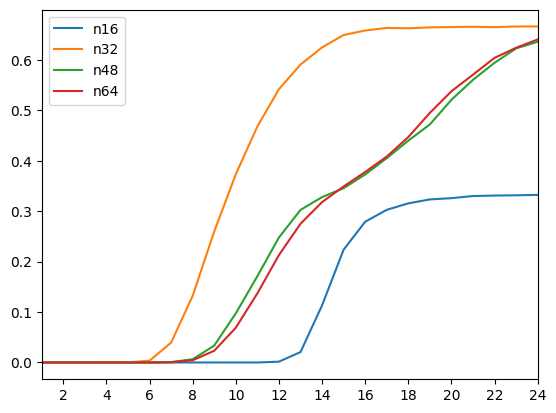

In [5]:
plt.clf()
ticks = np.arange(1,max_repeats+1)
plt.plot(ticks, np.array([r["state_acc"] for r in fa_16_rets]), label="n16")
plt.plot(ticks, np.array([r["state_acc"] for r in fa_32_rets]), label="n32")
plt.plot(ticks, np.array([r["state_acc"] for r in fa_48_rets]), label="n48")
plt.plot(ticks, np.array([r["state_acc"] for r in fa_64_rets]), label="n64")
plt.xlim(1,max_repeats)
plt.xticks([2 * k for k in range(1,13)])
plt.legend(loc="upper left")
;

In [6]:
@torch.no_grad()
def run_one_suppress_rule_attack(
    num_props,
    num_repeats,
    kappa = 32,
    num_samples = 2048,
    batch_size = 2048,
    verbose = False,
):
    assert num_samples % batch_size == 0
    n, k, bsz = num_props, num_repeats, batch_size
    zn = torch.zeros(bsz,1,n,device=device)
    model, _ = load_model_and_dataset(n, num_samples, models_dir, do_layer_norm=do_ln)
    model.eval().to(device)
    dataloader = DataLoader(SuppressRuleDataset(n,k,num_samples), bsz)
    elems_acc, state_acc = [], [] # Stats to track
    for batch in dataloader:
        infos = batch["infos"].to(device)
        a, b, c, d, e, f, g, h = infos.chunk(infos.size(-1), dim=-1)
        init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)
        # atk_rule = torch.cat([hot(c,n) + hot(d,n), -1*hot(f,n)], dim=-1).view(bsz,1,2*n)
        # atk_rule = torch.cat([hot(c,n) + hot(d,n), -1*hot(f,n)], dim=-1).view(bsz,1,2*n)
        ante = hot(c,n) + hot(d,n)
        conseq = hot(f,n) 
        atk_rule = torch.cat([ante, -conseq], dim=-1).view(bsz,1,2*n)
        adv_suffix = torch.cat([atk_rule.repeat(1,k,1), init_token], dim=1)
        out = model(torch.cat([batch["tokens"].to(device), adv_suffix], dim=1))
        pred = (out.logits > 0).long()
        labels = batch["labels"].to(device)
        elems_acc.append((pred == labels).float().mean().cpu().item())
        state_acc.append((pred == labels).all(dim=-1).float().mean().cpu().item())

    elems_acc = torch.tensor(elems_acc).float().mean().item()
    state_acc = torch.tensor(state_acc).float().mean().item()

    if verbose:
        print(f"num_props {n}, repeats {k}, elems {elems_acc:.3f}, state {state_acc:.3f}")
    return {
        "elems_acc": elems_acc,
        "state_acc": state_acc,
    }

In [7]:
max_repeats = 24
sr_16_rets, sr_32_rets, sr_48_rets, sr_64_rets = [], [], [], []
for k in tqdm(range(1,max_repeats+1)):
    sr_16_rets.append(run_one_suppress_rule_attack(num_props=16, num_repeats=k))
    sr_32_rets.append(run_one_suppress_rule_attack(num_props=32, num_repeats=k))
    sr_48_rets.append(run_one_suppress_rule_attack(num_props=48, num_repeats=k))
    sr_64_rets.append(run_one_suppress_rule_attack(num_props=64, num_repeats=k))

  0%|          | 0/24 [00:00<?, ?it/s]

''

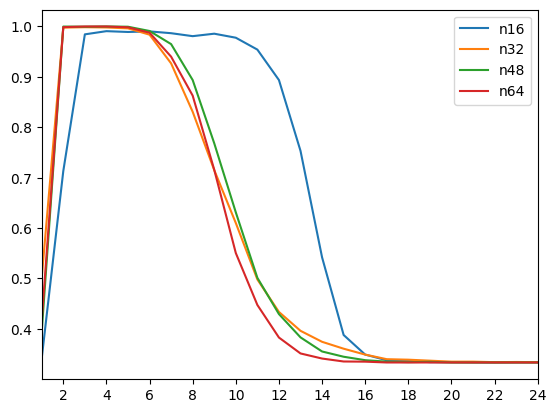

In [8]:
plt.clf()
ticks = np.arange(1,len(sr_16_rets)+1)
plt.plot(ticks, np.array([r["state_acc"] for r in sr_16_rets]), label="n16")
plt.plot(ticks, np.array([r["state_acc"] for r in sr_32_rets]), label="n32")
plt.plot(ticks, np.array([r["state_acc"] for r in sr_48_rets]), label="n48")
plt.plot(ticks, np.array([r["state_acc"] for r in sr_64_rets]), label="n64")
plt.xlim(1,max_repeats)
plt.xticks([2*k for k in range(1,13)])
plt.legend(loc="upper right")
;

In [32]:
n, k, bsz = 16, 16, 1024
zn = torch.zeros(bsz,1,n,device=device)
model, _ = load_model_and_dataset(num_props, bsz, models_dir, do_layer_norm=do_ln)
model.eval().to(device)
dataloader = DataLoader(SuppressRuleDataset(n,k,bsz), bsz)
for batch in dataloader:
    break

In [33]:
infos = batch["infos"].to(device)
a, b, c, d, e, f, g, h = infos.chunk(infos.size(-1), dim=-1)
init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)
# atk_rule = torch.cat([hot(c,n) + hot(d,n), -1*hot(f,n)], dim=-1).view(bsz,1,2*n)
# atk_rule = torch.cat([hot(c,n) + hot(d,n), -1*hot(f,n)], dim=-1).view(bsz,1,2*n)
ante = hot(c,n) + hot(d,n)
conseq = hot(f,n) 
atk_rule = torch.cat([ante, -conseq], dim=-1).view(bsz,1,2*n)
adv_suffix = torch.cat([atk_rule.repeat(1,k,1), init_token], dim=1)
out = model(torch.cat([batch["tokens"].to(device), adv_suffix], dim=1))
pred = (out.logits > 0).long()
labels = batch["labels"].to(device)
elems_acc = (pred == labels).float().mean().cpu().item()
state_acc = (pred == labels).all(dim=-1).float().mean().cpu().item()
print(elems_acc, state_acc)

0.9590250849723816 0.3444010615348816


In [19]:
out = model(tokens)
pred = (out.logits > 0).long()

In [18]:
out.logits

tensor([[[-9.2144,  8.1179,  9.7459,  ..., -9.5302, -8.9506, -8.7791],
         [ 7.7554,  6.3969,  6.5461,  ..., -8.1598, -8.2064, -8.3977],
         [ 9.7044,  5.8158,  7.8352,  ..., -8.9136, -8.2700, -9.1416]],

        [[-8.8389, 10.0420, -9.3412,  ..., -9.4397, -9.1070, -9.4581],
         [ 8.8132,  7.3500, -8.6134,  ..., -8.8681, -8.6335, -8.6776],
         [ 8.4654,  6.3581, -8.5929,  ..., -5.8774,  6.7992, -6.1006]],

        [[-8.6289, -8.6172, -9.2149,  ..., -8.9152,  8.5383, -8.6292],
         [-7.9838, -7.9306,  7.3038,  ..., -7.3233,  6.3488,  7.2647],
         [-9.4551, -8.9909, 11.8954,  ..., -6.2176,  5.9147,  9.3397]],

        ...,

        [[-8.7856, -8.9209,  8.3580,  ...,  8.6746, -9.6130, -9.0452],
         [-8.1451,  8.3736,  6.6331,  ...,  6.4552, -8.2197, -8.2512],
         [-7.3798,  9.7556,  6.6026,  ...,  6.5547, -8.4051, -8.1142]],

        [[-8.8841, -9.1723, -9.6362,  ...,  8.7637,  8.3596, -9.2466],
         [ 7.1320, -8.3408, -8.4172,  ...,  7.1648,  6.

In [10]:
@torch.no_grad()
def run_one_coerce_state_attack(
    num_props,
    num_samples = 2048,
    batch_size = 2048,
    kappa = 32,
    verbose = False,
):
    assert num_samples % batch_size == 0
    n, bsz = num_props, batch_size
    zn = torch.zeros(bsz,1,n,device=device)
    model, _ = load_model_and_dataset(n, num_samples, models_dir, do_layer_norm=do_ln)
    model.eval().to(device)
    dataloader = DataLoader(CoerceStateDataset(n,num_samples), bsz)
    elems_acc, state_acc = [], [] # Stats to track
    for batch in dataloader:
        infos = batch["infos"].to(device)
        a, b, c, d, e, f, g, h = infos.chunk(infos.size(-1), dim=-1)
        init_token = torch.cat([zn, hot(a,n)], dim=-1).view(bsz,1,2*n)

        tgt1, tgt2, tgt3 = batch["hints"].to(device).chunk(3, dim=1)
        tgt0 = hot(a,n).view(-1,1,n)
        atk_rule1 = torch.cat([tgt0, kappa*(tgt1 - 0.5)], dim=-1)
        atk_rule2 = torch.cat([tgt1, kappa*(tgt2 - 0.5)], dim=-1)
        atk_rule3 = torch.cat([tgt2, kappa*(tgt3 - 0.5)], dim=-1)
        adv_suffix = torch.cat([atk_rule1, atk_rule2, atk_rule3, init_token.view(bsz,1,-1)], dim=1)
        out = model(torch.cat([batch["tokens"].to(device), adv_suffix], dim=1))
        pred = (out.logits > 0).long()
        labels = batch["labels"].to(device)
        elems_acc.append((pred == labels).float().mean().cpu().item())
        state_acc.append((pred == labels).all(dim=-1).float().mean().cpu().item())

    elems_acc = torch.tensor(elems_acc).float().mean().item()
    state_acc = torch.tensor(state_acc).float().mean().item()

    if verbose:
        print(f"num_props {n}, repeats {k}, elems {elems_acc:.3f}, state {state_acc:.3f}")
    return {
        "elems_acc": elems_acc,
        "state_acc": state_acc,
    }

In [11]:
max_repeats = 24
cs_16_rets, cs_32_rets, cs_48_rets, cs_64_rets = [], [], [], []
for k in tqdm(range(1,max_repeats+1)):
    cs_16_rets.append(run_one_coerce_state_attack(num_props=16))
    cs_32_rets.append(run_one_coerce_state_attack(num_props=32))
    cs_48_rets.append(run_one_coerce_state_attack(num_props=48))
    cs_64_rets.append(run_one_coerce_state_attack(num_props=64))

  0%|          | 0/24 [00:00<?, ?it/s]

''

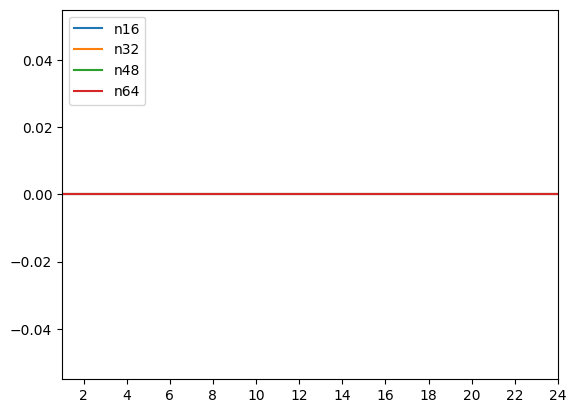

In [12]:
plt.clf()
ticks = np.arange(1,len(sr_16_rets)+1)
plt.plot(ticks, np.array([r["state_acc"] for r in cs_16_rets]), label="n16")
plt.plot(ticks, np.array([r["state_acc"] for r in cs_32_rets]), label="n32")
plt.plot(ticks, np.array([r["state_acc"] for r in cs_48_rets]), label="n48")
plt.plot(ticks, np.array([r["state_acc"] for r in cs_64_rets]), label="n64")
plt.xlim(1,max_repeats)
plt.xticks([2*k for k in range(1,13)])
plt.legend(loc="upper left")
;